# Human Activity Recognition Using Smartphones Dataset

This dataset compiled data from a Samsung smartphone's Accelerometer and Gyroscope sensors to identify common human activities such as Walking, Walking upstairs, Walking downstairs, Sitting, Standing and Lying down

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
#Let's get all 561 feature names yay!!!
features_df = pd.read_table(r'C:\Users\john.osorio\Desktop\BLACK CAT\Student Materials-20180820T065027Z-001\Student Materials\DataScience-AI-master\Labs\dat\Human Gesture detection via Smart Phone\UCI HAR Dataset\UCI HAR Dataset\features.txt',
                        sep = '\t', names = ['features'])

# This dataset has 561 features!!!

In [31]:
[features_df]

[                                     features
 0                         1 tBodyAcc-mean()-X
 1                         2 tBodyAcc-mean()-Y
 2                         3 tBodyAcc-mean()-Z
 3                          4 tBodyAcc-std()-X
 4                          5 tBodyAcc-std()-Y
 5                          6 tBodyAcc-std()-Z
 6                          7 tBodyAcc-mad()-X
 7                          8 tBodyAcc-mad()-Y
 8                          9 tBodyAcc-mad()-Z
 9                         10 tBodyAcc-max()-X
 10                        11 tBodyAcc-max()-Y
 11                        12 tBodyAcc-max()-Z
 12                        13 tBodyAcc-min()-X
 13                        14 tBodyAcc-min()-Y
 14                        15 tBodyAcc-min()-Z
 15                          16 tBodyAcc-sma()
 16                     17 tBodyAcc-energy()-X
 17                     18 tBodyAcc-energy()-Y
 18                     19 tBodyAcc-energy()-Z
 19                        20 tBodyAcc-iqr()-X
 20          

In [3]:
#Let's remove the annoying numbers before the feature names
feature_cols = pd.Series(features_df.features)
feature_array = []
for index, col_name in enumerate(range(1,562)):
    feature_array.append(feature_cols[index].replace(str(col_name) + ' ', ''))

In [4]:
#Get the training data
df_train = pd.read_table(r'C:\Users\john.osorio\Desktop\BLACK CAT\Student Materials-20180820T065027Z-001\Student Materials\DataScience-AI-master\Labs\dat\Human Gesture detection via Smart Phone\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt',
                  delim_whitespace = True, sep = '\t', names = feature_array, index_col=False)

C:\Users\john.osorio\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [6]:
#Let's add the test subject's ID into the training DF
subject_df = pd.read_table(r'C:\Users\john.osorio\Desktop\BLACK CAT\Student Materials-20180820T065027Z-001\Student Materials\DataScience-AI-master\Labs\dat\Human Gesture detection via Smart Phone\UCI HAR Dataset\UCI HAR Dataset\train\subject_train.txt',
                          names=['subject'])

In [7]:
#Create a new column named 'subject' and insert the subject_df
df_train['subject'] = subject_df

In [8]:
df_train['subject'].sort_values().value_counts()

25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: subject, dtype: int64

# I'll use subject 1 and see if we can make something out of it

# Let's find out which features to use based on PCA

In [9]:
X = df_train[:347]

Apply PCA
https://scikit-learn.org/stable/tutorial/statistical_inference/unsupervised_learning.html

In [10]:
from sklearn import decomposition
from mpl_toolkits import mplot3d
pca = decomposition.PCA()

In [11]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
print(pca.explained_variance_[0:10])

[37.67786735  4.08348099  1.66140662  1.06132447  0.90593486  0.64076439
  0.61994189  0.52096836  0.47634772  0.40395887]


It seems that the first 3 are more significant than the rest of them so let's plot them and see what we've got

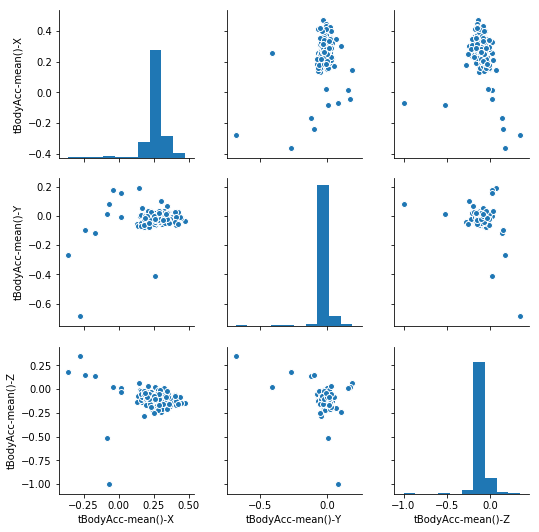

In [19]:
sns.pairplot(X.iloc[:, [0,1,2]])

Doesn't really look like much

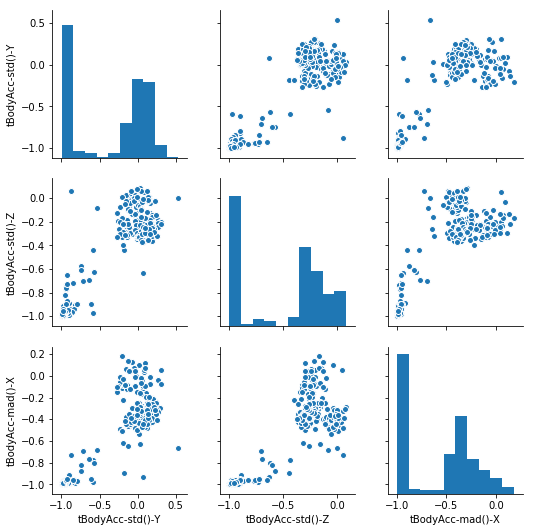

In [20]:
sns.pairplot(X.iloc[:, [4, 5, 6]])

This one looks better

# For a 3D view

Text(0.5,0,'tBodyAcc-std()-Z')

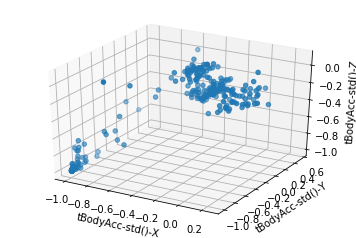

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(X.loc[:, ['tBodyAcc-std()-X']], X.loc[:, ['tBodyAcc-std()-Y']], X.loc[:, ['tBodyAcc-std()-Z']])
ax.set_xlabel('tBodyAcc-std()-X')
ax.set_ylabel('tBodyAcc-std()-Y')
ax.set_zlabel('tBodyAcc-std()-Z')

It appears that the time domain body accelerometer standard deviation presents better looking scatter plots

Use the KMeans elbow method to determine optimal number of clusters

In [26]:
X_new = X.loc[:, ['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z']]

In [27]:
distortions = []

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km.fit(X_new)
    distortions.append(sum(np.min(cdist(X_new, km.cluster_centers_, 'euclidean'), axis=1)) / X_new.shape[0])

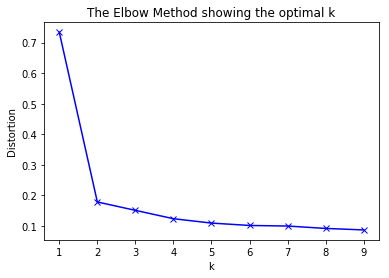

In [28]:
# Plot the elbow
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# It looks like only 2 clusters is the optimal number but I know that this dataset has 6 targets

# Kmeans method

In [32]:
#I'll go with two clusters first
kmeans_2 = KMeans(n_clusters=2).fit(X_new)

In [35]:
centroids = kmeans_2.cluster_centers_
centroids

array([[-0.2414565 ,  0.04304178, -0.19078232],
       [-0.97995702, -0.95369267, -0.94754182]])

In [37]:
len(centroids)

2

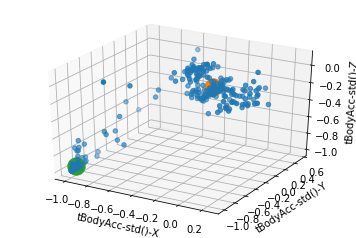

In [50]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(X.loc[:, ['tBodyAcc-std()-X']], X.loc[:, ['tBodyAcc-std()-Y']], X.loc[:, ['tBodyAcc-std()-Z']])
ax.set_xlabel('tBodyAcc-std()-X')
ax.set_ylabel('tBodyAcc-std()-Y')
ax.set_zlabel('tBodyAcc-std()-Z')

for index in range(len(centroids)):
    ax.scatter3D(centroids[index][0], centroids[index][1], centroids[index][2], s = 300)

# Agglomerative method

In [51]:
Agglo = AgglomerativeClustering(linkage='ward', n_clusters=2)
Agglo.fit(X_new)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x00000042E81C78C8>)

In [53]:
agglo_labels = Agglo.labels_

Text(0.5,0,'tBodyAcc-std()-Z')

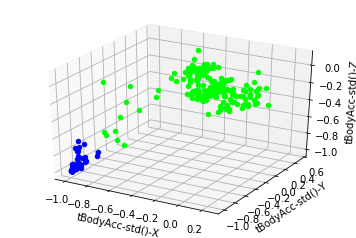

In [60]:
color = ['#00FF00', '#0000FF']

fig = plt.figure()
ax = plt.axes(projection='3d')

for index in range(X_new.shape[0]):
    ax.scatter3D(X.loc[index, ['tBodyAcc-std()-X']], X.loc[index, ['tBodyAcc-std()-Y']], X.loc[index, ['tBodyAcc-std()-Z']], c = color[agglo_labels[index]])

ax.set_xlabel('tBodyAcc-std()-X')
ax.set_ylabel('tBodyAcc-std()-Y')
ax.set_zlabel('tBodyAcc-std()-Z')